# Demo for Pixel Deflection - a simple transformation based defense

## Change local pixel arrangement and then denoise using wavelet transform

Paper: https://arxiv.org/abs/1801.08926

Code : https://github.com/iamaaditya/pixel-deflection

**What**

1. Select a random pixel and replace it with another randomly selected pixel from a local neighbourhod; we call this as pixel deflection (PD).

2. Use a class-activation type map (R-CAM) to select the pixel to deflect. Less important the pixel for classification higher the chances that it will get deflected.

3. Do a soft shrinkage over wavelet domain to remove the added noise (WD).

**Why**

1. PD changes local staticstics without affecting the global statistics. Adversarial examples rely on specific activations; PD changes that but not enough to change overall image category.

2. Most attacks are agnostic to presence of semantic objects in the image; by picking more pixels outside the regions-of-interest we increase likelihood of destroying the adversarial pertubation but not much of the content.

3. Classifiers are trained on images without such (PD) noises. We can smoothen the impact of such noise by denoising, for which we found out that BayesShrink on DWT works best.

## Load the requirements

In [160]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from random import randint, uniform

### Load the classifier
Classifier can be easily changed to inception_v3, vgg19, xception, etc see 
https://github.com/iamaaditya/pixel-deflection/blob/master/main.py#L65


In [ ]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
model = ResNet50(weights='imagenet')

In [145]:
def load_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img = image.img_to_array(img)
    true_label = img_path.split('/')[-1].split('_')[0]
    return img, true_label

In [153]:
def visualize_classification(class_names, probs, image, true_class=-1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.sca(ax1)
    
    ax1.imshow(image.astype('uint8'))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Image')
    
    y_pos = np.arange(len(class_names))
    barlist = ax2.bar(y_pos, probs, align='center', alpha=0.5)
    if true_class >= 0 and true_class <= 4:
        barlist[true_class].set_color('g')
    ax2.set_xticks(y_pos, minor=False)
    ax2.set_xticklabels(class_names, minor=False, rotation='vertical')
    ax2.set_ylabel('Probability of given class')
    ax2.set_title('Classification')
   
    for bar in barlist:
        v = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., 1.02*v, '%.2f' % v, ha='center')

In [200]:
def classify_images(images_arr, true_label, visualize=False):
    images = preprocess_input(np.stack(images_arr,axis=0))
    predictions = decode_predictions(model.predict(images),top=5)
    labels, class_names, probs = [], [], []
    for p in predictions:
        labels.append([i[0] for i in p])
        class_names.append([i[1] for i in p])
        probs.append([i[2] for i in p])
    
    if visualize:
        label_index = labels[0].index(true_label) if true_label in labels[0] else -1
        visualize_classification(class_names[0], probs[0], images_arr[0], label_index)
    
    return labels, class_names, probs

In [215]:
def denoiser(img):
    return denoise_wavelet(img/255.0, sigma=0.04, mode='soft', multichannel=True, convert2ycbcr=True, method='BayesShrink')*255.0

## Load and classify the original

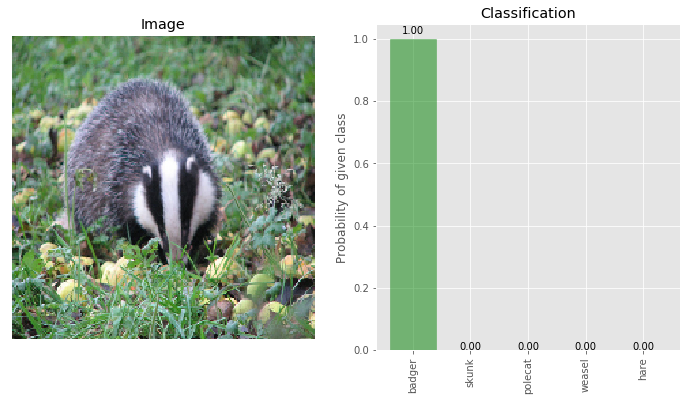

In [256]:
#img, true_label = load_image('originals/n02443114_00000055.png')
img, true_label = load_image('originals/n02447366_00008562.png')
_ = classify_images([img], true_label, visualize=True)

Green color bar indicates the 'true' class of the image. 
Image was correctly classified as **'badger'** with 100% confidence.

## Load and classify the adversarial image

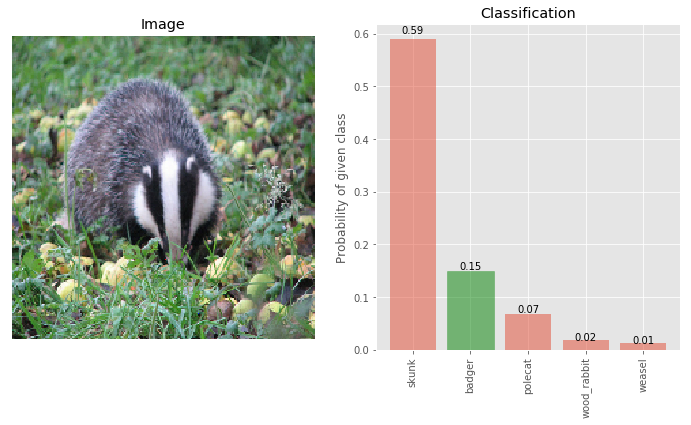

In [257]:
img, true_label = load_image('images/n02447366_00008562.png')
_ = classify_images([img], true_label, visualize=True)

The true class **'badger'** is now only 15% and __'skunk'__ is the most likely class with 60% classification.
This adversary was obtained using IGSM attack model. [See this](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/attacks.py#L321) for the attack code.

## Pixel Deflection

In our paper we use pixel deflection with a heatmap, but first lets look at pixel deflection without any maps.

In [282]:
def pixel_deflection_without_map(img, deflections, window):
    img = np.copy(img)
    H, W, C = img.shape
    while deflections > 0:
        #for consistency, when we deflect the given pixel from all the three channels.
        for c in range(C):
            x,y = randint(0,H-1), randint(0,W-1)
            while True: #this is to ensure that PD pixel lies inside the image
                a,b = randint(-1*window,window), randint(-1*window,window)
                if x+a < H and x+a > 0 and y+b < W and y+b > 0: break
            # calling pixel deflection as pixel swap would be a misnomer,
            # as we can see below, it is one way copy
            img[x,y,c] = img[x+a,y+b,c] 
        deflections -= 1
    return img

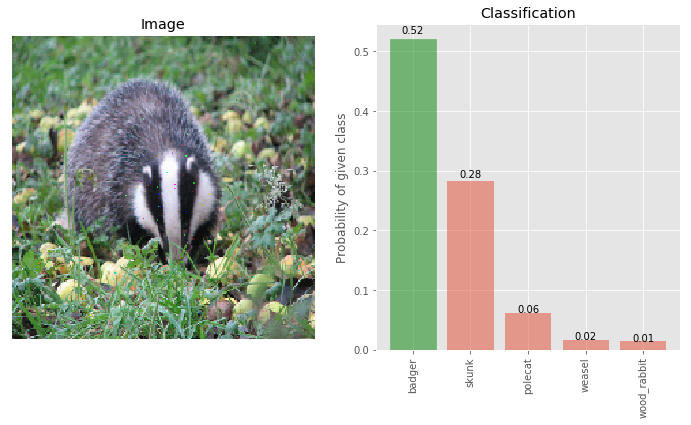

In [274]:
img_deflected = pixel_deflection_without_map(img, deflections=200, window=20)
_ = classify_images([img_deflected], true_label, visualize=True)

### Let's see the pixels that were deflected.

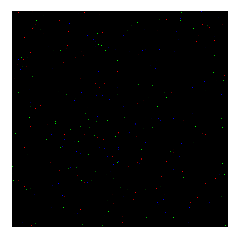

In [281]:
diff = img - img_deflected
plt.imshow(diff.astype('uint8'))
_=plt.xticks([])
_=plt.yticks([])

Since we are not using any map, probability of selecting any pixel in the image is equally likely.


In [181]:
from skimage.restoration import denoise_wavelet

In [187]:
img2 = denoise_wavelet(img_deflected/255.0, sigma=0.04, mode='soft', multichannel=True, convert2ycbcr=True, method='BayesShrink')*255.0

([[u'n02443484', u'n02441942', u'n02443114', u'n02342885', u'n02442845']],
 [[u'black-footed_ferret', u'weasel', u'polecat', u'hamster', u'mink']],
 [[0.97667694, 0.0122447, 0.0081524681, 0.0025866898, 0.000271222]])

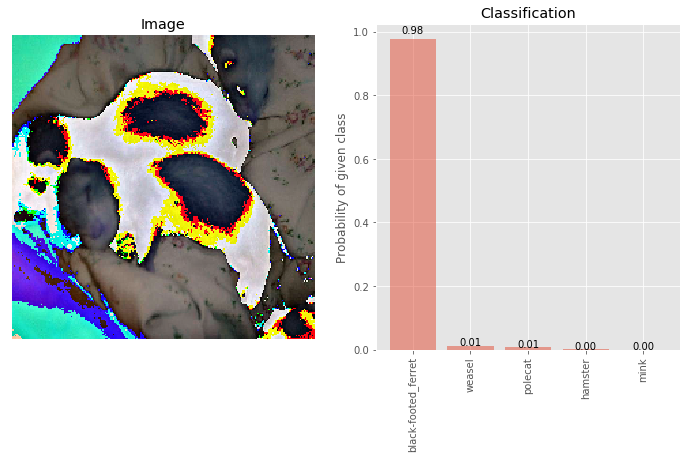

In [191]:
classify_images([img])
